Authors: Fernando Díaz González and Giorgio Ruffa
{fdiaz, ruffa}@kth.se

ID 2222 Data Mining. Assignment 4

In [1]:
import networkx as nx
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import scipy

from collections import defaultdict
from networkx import Graph
from sklearn.cluster import KMeans

# Graph Spectra

Implementation of the paper:

Andrew Y. Ng, Michael I. Jordan, and Yair Weiss. 2001. On spectral clustering: analysis and an algorithm. In Proceedings of the 14th International Conference on Neural Information Processing Systems: Natural and Synthetic (NIPS'01).

## Toy example

In [2]:
test_graph = nx.read_edgelist('test_graph.edgelist', create_using=Graph, edgetype=str)

/home/fernando/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


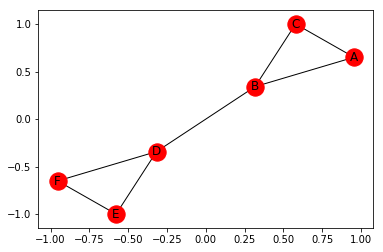

In [3]:
nx.draw_networkx(test_graph)

1. Form the affinity matrix $A \in \mathbb{R}^{n \times n}$ defined by $A_{ij} = exp(-||s_i - s_j||^2 / 2\sigma^2)$ if $i \ne j$, and $A_{ii} = 0$. 

In [4]:
A = nx.adjacency_matrix(test_graph)
print('A matrix:')
print(A.todense())

A matrix:
[[0 1 1 0 0 0]
 [1 0 1 1 0 0]
 [1 1 0 0 0 0]
 [0 1 0 0 1 1]
 [0 0 0 1 0 1]
 [0 0 0 1 1 0]]


2. Define $D$ to be the diagonal matrix whose $(i, i)$-element is the sum of $A$'s $i$-th
row, and construct the matrix $L = D^{-1/2} A D^{-1/2}$. 

In [5]:
np.set_printoptions(precision=3)

D = np.zeros(A.shape)
# axis=1 -> sum per row
grades = A.sum(axis=1)
np.fill_diagonal(D, grades)
print('D matrix:')
print(D)
print()

D_p = D.copy()
np.fill_diagonal(D_p, 1 / np.sqrt(grades))
print('D^-0.5 matrix')
print(D_p)
print()

L = D_p.dot(A.todense()).dot(D_p)
# Also valid
# L = -nx.normalized_laplacian_matrix(test_graph)
print('L matrix:')
print(L)
print()

D matrix:
[[2. 0. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 3. 0. 0.]
 [0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 2.]]

D^-0.5 matrix
[[0.707 0.    0.    0.    0.    0.   ]
 [0.    0.577 0.    0.    0.    0.   ]
 [0.    0.    0.707 0.    0.    0.   ]
 [0.    0.    0.    0.577 0.    0.   ]
 [0.    0.    0.    0.    0.707 0.   ]
 [0.    0.    0.    0.    0.    0.707]]

L matrix:
[[0.    0.408 0.5   0.    0.    0.   ]
 [0.408 0.    0.408 0.333 0.    0.   ]
 [0.5   0.408 0.    0.    0.    0.   ]
 [0.    0.333 0.    0.    0.408 0.408]
 [0.    0.    0.    0.408 0.    0.5  ]
 [0.    0.    0.    0.408 0.5   0.   ]]



3. Find $x_1, x_2, \cdots , x_k$, the $k$ largest eigenvectors of $L$ (chosen to be orthogonal to each other in the case of repeated eigenvalues), and form the matrix $X = [x_1 x_2 \cdots x_k] \in \mathbb{R}^{n \times k}$ by stacking the eigenvectors in columns. 

In [6]:
eigenval, eigenvec = np.linalg.eig(L)
eigenvec = eigenvec.T
print('Eigenvalues: ', eigenval)
print('Eigenvectors:', eigenvec)
print()

k = 2
idx_sorted = np.argsort(eigenval)[::-1]
largest_eigenval = eigenval[idx_sorted[:k]]
largest_eigenvec = eigenvec[idx_sorted[:k]]
X = largest_eigenvec.T

print('Largest {} eigenvalues are: {}\n'.format(k, largest_eigenval))
print('Largest {} eigenvectors are:'.format(k))
print(largest_eigenvec)
print()
print('Matrix X is:')
print(X)

Eigenvalues:  [ 1.     0.795 -0.167 -0.5   -0.629 -0.5  ]
Eigenvectors: [[-3.780e-01 -4.629e-01 -3.780e-01 -4.629e-01 -3.780e-01 -3.780e-01]
 [-4.451e-01 -3.220e-01 -4.451e-01  3.220e-01  4.451e-01  4.451e-01]
 [-3.273e-01  5.345e-01 -3.273e-01  5.345e-01 -3.273e-01 -3.273e-01]
 [-7.071e-01  7.378e-16  7.071e-01 -1.032e-15  1.953e-16  3.179e-16]
 [-2.277e-01  6.295e-01 -2.277e-01 -6.295e-01  2.277e-01  2.277e-01]
 [-1.321e-01  9.358e-16  1.321e-01 -1.095e-15 -6.947e-01  6.947e-01]]

Largest 2 eigenvalues are: [1.    0.795]

Largest 2 eigenvectors are:
[[-0.378 -0.463 -0.378 -0.463 -0.378 -0.378]
 [-0.445 -0.322 -0.445  0.322  0.445  0.445]]

Matrix X is:
[[-0.378 -0.445]
 [-0.463 -0.322]
 [-0.378 -0.445]
 [-0.463  0.322]
 [-0.378  0.445]
 [-0.378  0.445]]


4. Form the matrix $Y$ from $X$ by renormalizing each of $X$'s rows to have unit length (i.e. $Y_{ij} = X_{ij} / (\sum_j X_{ij}^2)^{1/2}$). 

In [7]:
Y = X / np.sqrt(np.sum(np.square(X), axis=1))
print('Y:')
print(Y)
print()

print('Modulus of rows of Y:')
print(np.sum(np.square(Y), axis=1))

Y:
[[-0.647 -0.762]
 [-0.821 -0.571]
 [-0.647 -0.762]
 [-0.821  0.571]
 [-0.647  0.762]
 [-0.647  0.762]]

Modulus of rows of Y:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


5. Treating each row of $Y$ as a point in $\mathbb{R}^k$, cluster them into $k$ clusters via K-means
or any other algorithm (that attempts to minimize distortion).

In [8]:
kmeans_res = KMeans(n_clusters=k).fit(Y)

6.  Finally, assign the original point $S_i$ to cluster $j$ if and only if row $i$ of the matrix
$Y$ was assigned to cluster $j$.

In [9]:
# Drawing "big" graphs is OK. But use with_labels=False
def draw_network_clusters(graph, cluster_assign, node_size=300, with_labels=True):
    k = len(np.unique(cluster_assign))
    nodes = np.array(list(graph.nodes))
    labels = {node: str(node) for node in nodes}
    cmap = plt.cm.get_cmap('Set1', k+1)

    pos = nx.spring_layout(graph, seed=42)
    for ki in range(k):
        n_indexes = np.where(cluster_assign == ki)
        n = list(nodes[n_indexes])
        rgb = cmap(ki)[:3]
        color = matplotlib.colors.rgb2hex(rgb)
        nx.draw_networkx_nodes(test_graph, pos, nodelist=n, 
                               node_color=color, node_size=node_size)
        if with_labels:
            nx.draw_networkx_labels(test_graph, pos, labels=labels, node_color=color)
    nx.draw_networkx_edges(graph, pos)
    
def draw_compare(graph, cluster_assign, node_size=300, with_labels=True):
    f = plt.figure(figsize=(15, 5))
    ax = f.add_subplot(121)
    nx.draw_networkx(graph, pos=nx.spring_layout(graph, seed=42), 
                     node_size=node_size, with_labels=with_labels)
    plt.title('Original')
    ax2 = f.add_subplot(122)
    draw_network_clusters(graph, cluster_assign, 
                          node_size=node_size, with_labels=with_labels)
    plt.title('Clusters assigned')
    plt.show()

/home/fernando/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


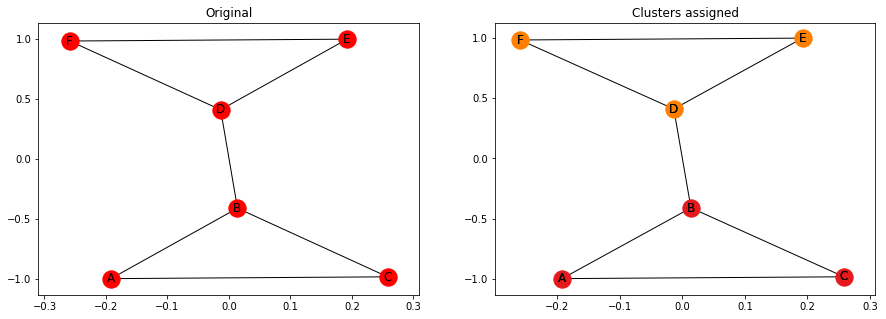

In [10]:
draw_compare(test_graph, kmeans_res.labels_)

## Test with real graph

In [11]:
ex1 = nx.read_edgelist('example1.dat', delimiter=',', create_using=Graph, edgetype=int)
print('Number of nodes: {}. Number of edges {}'.format(ex1.number_of_nodes(), ex1.number_of_edges()))

Number of nodes: 241. Number of edges 923


In [12]:
ex2 = nx.read_weighted_edgelist('example2.dat', delimiter=',', create_using=Graph)
print('Number of nodes: {}. Number of edges {}'.format(ex1.number_of_nodes(), ex1.number_of_edges()))

Number of nodes: 241. Number of edges 923


In [13]:
def spectral_clustering(graph, k=None):
    A = nx.adjacency_matrix(graph)
    D = np.zeros(A.shape)
    grades = np.sum(A.todense(), axis=1)
    np.fill_diagonal(D, 1 / np.sqrt(grades))
    L = D.dot(A.todense()).dot(D)
    A = D = grades = None  # free memory
    eigenval, eigenvec = np.linalg.eig(L)
    eigenvec = eigenvec.T  # result was column-wise
    # Use eigenvalues to find the best k
    if k == None:
        k = find_best_k(eigenval)
        print('Found best k =', k)
    idx_sorted = np.argsort(eigenval)[::-1]
    largest_eigenvec = eigenvec[idx_sorted[:k]]
    X = largest_eigenvec.T
    Y = X / np.sqrt(np.sum(np.square(X), axis=1))
    np.nan_to_num(Y, copy=False)  # valid? (sometimes, rows of X are all 0's)
    kmeans_res = KMeans(n_clusters=k).fit(Y)
    return kmeans_res.labels_, eigenval

def find_best_k(eigenval, delta=0.1):
    # Check if the difference between two eigenvalues (sorted desc) changes radically
    # The difference between eigen1 and eigen2 is always ok
    # E.g. [1, 0.9, 0.8, 0.6] (1 - 0.9) = 0.1 (ok), (0.9 - 0.8) = 0.1 (ok), (0.8 - 0.6) = 0.2 (stop)
    # E.g. [1, 0.5, 0.4, -0.6] (1 - 0.5) = 0.5 (ok), (0.5 - 0.4) = 0.1 (stop)
    # I agree that last example is a little bit weird, but let's consider that minimum k = 2
    # It works anyway!
    eigenval_sorted = sorted(eigenval, reverse=True)
    previous_diff = eigenval_sorted[0] - eigenval_sorted[1]
    for k in range(1, len(eigenval_sorted)):
        current_diff = eigenval_sorted[k - 1] - eigenval_sorted[k]
        if abs(current_diff - previous_diff) > delta:
            return k
        previous_diff = current_diff
    # If we are here we are DOOMED anyway
    return len(eigenval)

In [14]:
ex1_clusters, ex1_eigenval = spectral_clustering(ex1, k=None)

Found best k = 4


/home/fernando/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


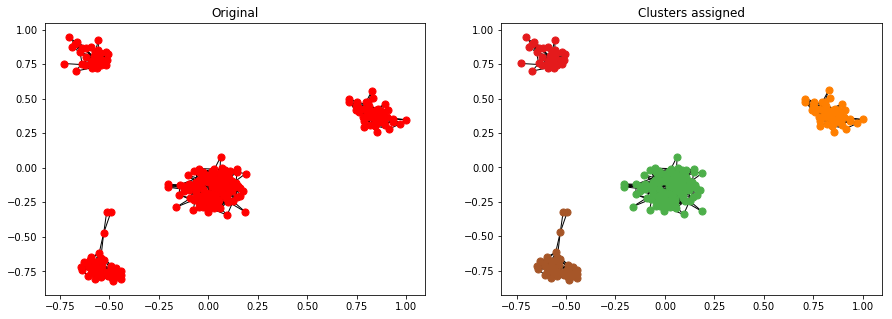

In [15]:
draw_compare(ex1, ex1_clusters, node_size=50, with_labels=False)

First 11 eigenvalues (sorted):
[1.0000000000000053, 1.0000000000000036, 1.0000000000000022, 1.0000000000000013, 0.8323227183309407, 0.7785133509368769, 0.7534709952573879, 0.7508064940326453, 0.7366176410796733, 0.7267992817159747, 0.6376313298484297]


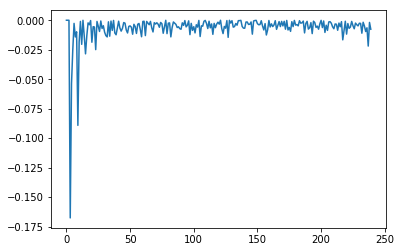

In [16]:
ex1_eigenval_sorted = sorted(ex1_eigenval, reverse=True)
print('First 11 eigenvalues (sorted):')
print(ex1_eigenval_sorted[:11])
plt.plot(range(len(ex1_eigenval_sorted) - 1), np.diff(ex1_eigenval_sorted))

In [17]:
ex1_clusters, ex1_eigenval = spectral_clustering(ex1, k=10)

/home/fernando/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


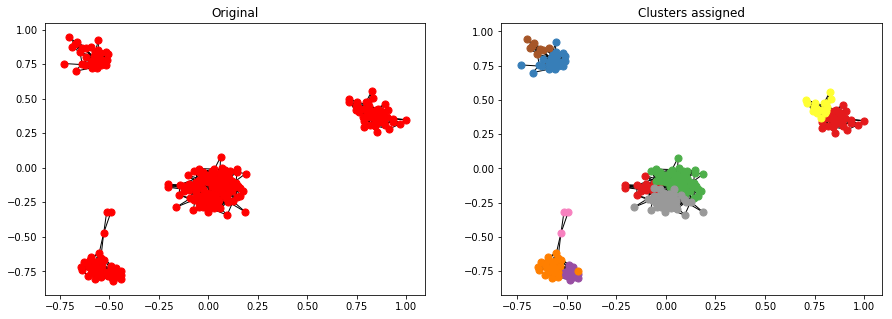

In [18]:
draw_compare(ex1, ex1_clusters, node_size=50, with_labels=False)

In [19]:
ex2_clusters, ex2_eigenval = spectral_clustering(ex2, k=None)

Found best k = 2


/home/fernando/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


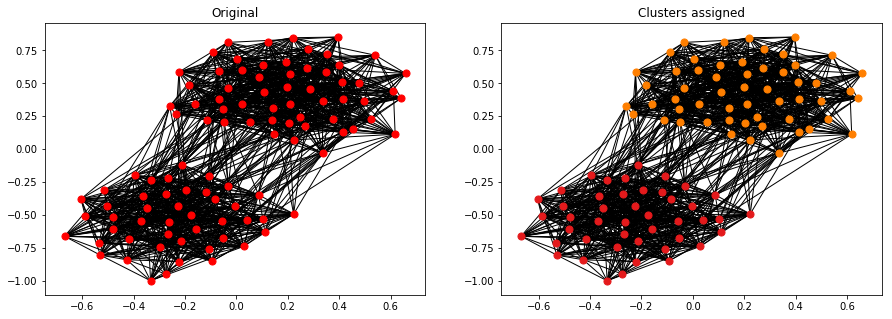

In [20]:
draw_compare(ex2, ex2_clusters, node_size=50, with_labels=False)

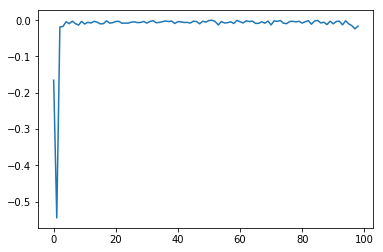

In [21]:
ex2_eigenval_sorted = sorted(ex2_eigenval, reverse=True)
plt.plot(range(len(ex2_eigenval_sorted) - 1), np.diff(ex2_eigenval_sorted))